### Make OpenEO connection

In [4]:
import openeo
connection = openeo.connect("https://openeo.dataspace.copernicus.eu/").authenticate_oidc()

Authenticated using refresh token.


In [5]:
#Get desired data
from preprocessing import worldcereal_preprocessed_inputs

EXTENT = dict(zip(["west", "south", "east", "north"], [5.191984, 51.256920, 5.215158, 51.267661]))
EXTENT['crs'] = "EPSG:4326"

STARTDATE = '2020-11-01'
ENDDATE = '2021-10-31'

# Set OpenEO classification UDF context based on settings
CONTEXT = {
    "startdate": STARTDATE,  # Required
    "enddate": ENDDATE,      # Required
}

input_cube = worldcereal_preprocessed_inputs(
     connection,
     EXTENT,
     STARTDATE,
     ENDDATE,
     METEO_collection=None,
     S2_collection= "SENTINEL2_L2A",
     S1_collection= "SENTINEL1_GRD",
     DEM_collection= "COPERNICUS_30"
)




In [6]:

udf = openeo.UDF.from_file("udf_worldcereal_inference.py")

prediction = input_cube.apply_neighborhood(
    process=udf,
    size=[
        {"dimension": "x", "value": 100, "unit": "px"},
        {"dimension": "y", "value": 100, "unit": "px"},
    ],
    overlap=[
        {"dimension": "x", "value": 0, "unit": "px"},
        {"dimension": "y", "value": 0, "unit": "px"},
    ],
)


prediction.execute_batch(outputfile = 'test_output_worldcereal.nc',
                                description='world cereal inference',
                                job_options={'driver-memory': '1g',                  
                                    })


0:00:00 Job 'j-240506caa9a448be8d26ea574243765e': send 'start'
0:00:13 Job 'j-240506caa9a448be8d26ea574243765e': created (progress N/A)
0:00:19 Job 'j-240506caa9a448be8d26ea574243765e': created (progress N/A)
0:00:25 Job 'j-240506caa9a448be8d26ea574243765e': created (progress N/A)
0:00:33 Job 'j-240506caa9a448be8d26ea574243765e': created (progress N/A)
0:00:44 Job 'j-240506caa9a448be8d26ea574243765e': created (progress N/A)
0:00:56 Job 'j-240506caa9a448be8d26ea574243765e': created (progress N/A)
0:01:12 Job 'j-240506caa9a448be8d26ea574243765e': running (progress N/A)
0:01:31 Job 'j-240506caa9a448be8d26ea574243765e': running (progress N/A)
0:01:55 Job 'j-240506caa9a448be8d26ea574243765e': running (progress N/A)
0:02:34 Job 'j-240506caa9a448be8d26ea574243765e': running (progress N/A)
0:03:12 Job 'j-240506caa9a448be8d26ea574243765e': running (progress N/A)
0:03:58 Job 'j-240506caa9a448be8d26ea574243765e': running (progress N/A)
0:04:57 Job 'j-240506caa9a448be8d26ea574243765e': running (pr

### Check result

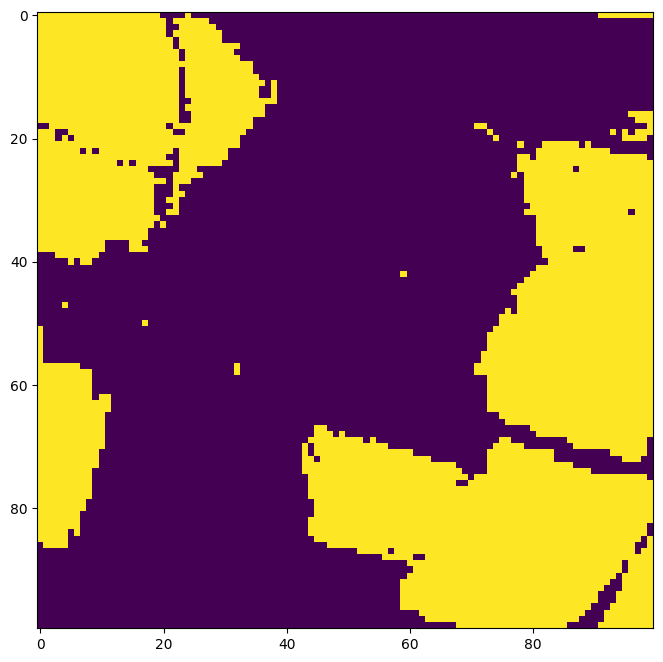

In [7]:
import matplotlib.pyplot as plt
results = result_cube.array.values.squeeze()

f, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.imshow(results)

In [2]:
from pathlib import Path  
import sys
import urllib.request
import shutil

import requests
import xarray as xr


#GET DEPENDENCIES

 # Generate absolute path for the dependencies folder
dependencies_dir = Path.cwd() / 'dependencies'
dependencies_dir.mkdir(exist_ok=True, parents=True)

base_url = 'https://artifactory.vgt.vito.be/artifactory/auxdata-public/worldcereal-minimal-inference'
dependency_name = "wc_presto_onnx_dependencies.zip"

# Download and extract the model file
modelfile_url = f"{base_url}/{dependency_name}"
modelfile, _ = urllib.request.urlretrieve(modelfile_url, filename=dependencies_dir / Path(modelfile_url).name)
shutil.unpack_archive(modelfile, extract_dir=dependencies_dir)

# Add the model directory to system path if it's not already there
abs_path = str(dependencies_dir / Path(modelfile_url).name.split('.zip')[0])
sys.path.append(abs_path)


# Get Data
url = "https://artifactory.vgt.vito.be/artifactory/auxdata-public/worldcereal-minimal-inference/belgium_good_2020-12-01_2021-11-30.nc"
filename = "belgium_good_2020-12-01_2021-11-30.nc"

with requests.get(url, stream=True) as r:
    r.raise_for_status()
    with open(filename, 'wb') as f:
        for chunk in r.iter_content(chunk_size=8192):
            f.write(chunk)

# Read the file into xarray
ds = xr.open_dataset(filename)
arr = ds.drop('crs').to_array(dim='bands')
orig_dims = list(arr.dims)
orig_dims.remove("t")

#Get Presto
from dependencies.wc_presto_onnx_dependencies.mvp_wc_presto.world_cereal_inference import get_presto_features, classify_with_catboost

#bands: 19, t: 12y, : 100x: 100y
data_url  = 'https://artifactory.vgt.vito.be/artifactory/auxdata-public/worldcereal-minimal-inference/belgium_good_2020-12-01_2021-11-30.nc'
# Fetch the data from the URL
response = requests.get(data_url)
#100x100,128
presto_path = "https://artifactory.vgt.vito.be/artifactory/auxdata-public/worldcereal-minimal-inference/presto.pt"
features = get_presto_features(arr, presto_path) 

#Get CATBOOST
CATBOOST_PATH = 'https://artifactory.vgt.vito.be/artifactory/auxdata-public/worldcereal-minimal-inference/wc_catboost.onnx'
classification = classify_with_catboost(features, orig_dims, CATBOOST_PATH)



C:\Users\VROMPAYH\AppData\Local\Temp\ipykernel_31284\122910811.py:21: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  arr = ds.drop('crs').to_array(dim='bands')


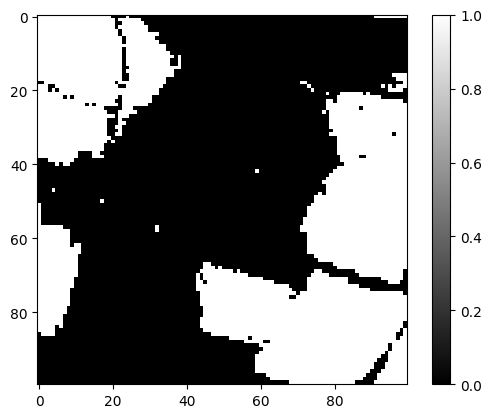

In [3]:
import matplotlib.pyplot as plt
import numpy as np

data_array = np.array(classification)

# Plot the data as an image
plt.imshow(data_array[0], cmap='gray')  # Assuming it's a grayscale image
plt.colorbar()  # Add a colorbar for reference
plt.show()